# COVID-19 Tweets Sentiment Analysis
### By: Andrej Pozderac, Andrew Edward, Faaiz Joad
# -----------------------------------------------------------------------------
Loading all necessary libraries

In [58]:
import pandas as pd
import re
import nltk
import collections
import string
import numpy as np
import sklearn
import gzip
import csv
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from time import time
from nltk import bigrams
import itertools
import collections
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import networkx as nx
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# from plotnine import *
# from plotnine.data import *
import plotly as py
import plotly.express as px

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# -----------------------------------------------------------------------------
Loading the tweets data

In [5]:
covid_19_tweets = pd.read_csv('final_tweets.csv')

In [6]:
covid_19_tweets

,Date,Tweet,User,Keyword
0,11/26/2020,OlgaNYC1211 Me Hello FBI and DHSgov Id like to...,HereNowForever1,COVID
1,11/26/2020,gilliland1tide Must have been a contest of the...,profstan72,COVID
2,11/26/2020,I invented a diet called the Chimp Diet You ea...,blackbettyblog,corona
3,11/26/2020,People have told youll find the one someday So...,GravityOcean13,corona
4,11/26/2020,I havent seen mfs in a while This COVID19 fuck...,In_Jay_We_Trust,COVID
...,...,...,...,...
25822,03/01/2020,People its CoronaVirus or COVID19 Pick one Als...,_lydiamj,COVID
25823,03/01/2020,swkoti Rice Pasta Canned soup Getting ready fo...,babybellarose,COVID
25824,03/01/2020,Theyre chasing me the journalist who wouldnt s...,amici09,COVID
25825,03/01/2020,Calling it now it will be the 2021 Summer Olym...,kraichdm,COVID


In [7]:
covid_19_tweets['Date'] = covid_19_tweets['Date'].apply(lambda row: row.split('/')[0])
covid_19_tweets

,Date,Tweet,User,Keyword
0,11,OlgaNYC1211 Me Hello FBI and DHSgov Id like to...,HereNowForever1,COVID
1,11,gilliland1tide Must have been a contest of the...,profstan72,COVID
2,11,I invented a diet called the Chimp Diet You ea...,blackbettyblog,corona
3,11,People have told youll find the one someday So...,GravityOcean13,corona
4,11,I havent seen mfs in a while This COVID19 fuck...,In_Jay_We_Trust,COVID
...,...,...,...,...
25822,03,People its CoronaVirus or COVID19 Pick one Als...,_lydiamj,COVID
25823,03,swkoti Rice Pasta Canned soup Getting ready fo...,babybellarose,COVID
25824,03,Theyre chasing me the journalist who wouldnt s...,amici09,COVID
25825,03,Calling it now it will be the 2021 Summer Olym...,kraichdm,COVID


In [8]:
def clean_tweet(tweet):
    #Step 1 - drop links
    regex = re.compile(r'https?://t.co/[a-zA-Z0-9]{10}')
    remove_links = re.split(regex,tweet)
    remove_links = ' '.join(remove_links)

    #Step 2 - Remove any non-ascii characters
    remove_non_ascii =  re.sub(r'[^\x00-\x7F]+',' ', remove_links).lower()

    #Step 3 - check for apostrophes
    remove_apostroph = remove_non_ascii.replace("'s","")
    remove_apostroph = remove_apostroph.replace("'","")
    remove_apostroph = remove_apostroph.split(' ')
    
    #Step 4 - Remove dashes
    remove_dashes = ' '.join(remove_apostroph).split('-')
    remove_dashes = ' '.join(remove_dashes)

    #Step 5 - Keep letters and digits only
    keep_letters =  re.sub(r'[^a-zA-Z0-9]',' ', remove_dashes)

    keep_letters = keep_letters.split(' ')

    keep_letters = ' '.join(keep_letters)

    #Step 6 - Tokenize 
    tokenize = nltk.word_tokenize(keep_letters)

    #Step 7 - Lemmatize    
    lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
    lemmatize_text = map(lambda x: lemmatizer.lemmatize(x), tokenize)

    #Step 8 - Remove stop words
    stopwords = set(nltk.corpus.stopwords.words('english'))
    remove_stop = list(filter(lambda x: x not in stopwords, lemmatize_text))

    #Step 9 - Remove any empty strings from list
    processed_list = list(filter(lambda a: a != "", remove_stop))

    processed_string = " ".join(processed_list)

    return processed_string

In [9]:
covid_19_tweets['Tweet'] = covid_19_tweets['Tweet'].apply(lambda x: clean_tweet(x))

# -------------------------------------------------------------------------

In [10]:
def sent_to_list(sentence):
    return sentence.split(" ")

In [11]:
covid_19_tweets['words_list'] = covid_19_tweets['Tweet'].apply(lambda x: sent_to_list(x))

In [12]:
covid_19_tweets_3 = covid_19_tweets.loc[covid_19_tweets['Date'] == '03']
covid_19_tweets_4 = covid_19_tweets.loc[covid_19_tweets['Date'] == '04']
covid_19_tweets_5 = covid_19_tweets.loc[covid_19_tweets['Date'] == '05']
covid_19_tweets_6 = covid_19_tweets.loc[covid_19_tweets['Date'] == '06']
covid_19_tweets_7 = covid_19_tweets.loc[covid_19_tweets['Date'] == '07']
covid_19_tweets_8 = covid_19_tweets.loc[covid_19_tweets['Date'] == '08']
covid_19_tweets_9 = covid_19_tweets.loc[covid_19_tweets['Date'] == '09']
covid_19_tweets_10 = covid_19_tweets.loc[covid_19_tweets['Date'] == '10']
covid_19_tweets_11 = covid_19_tweets.loc[covid_19_tweets['Date'] == '11']
covid_19_tweets_11

,Date,Tweet,User,Keyword,words_list
0,11,olganyc1211 hello fbi dhsgov id like report ac...,HereNowForever1,COVID,"[olganyc1211, hello, fbi, dhsgov, id, like, re..."
1,11,gilliland1tide must contest three worst disast...,profstan72,COVID,"[gilliland1tide, must, contest, three, worst, ..."
2,11,invented diet called chimp diet eat mostly fru...,blackbettyblog,corona,"[invented, diet, called, chimp, diet, eat, mos..."
3,11,people told youll find one someday like whens ...,GravityOcean13,corona,"[people, told, youll, find, one, someday, like..."
4,11,havent seen mf covid19 fucked link,In_Jay_We_Trust,COVID,"[havent, seen, mf, covid19, fucked, link]"
...,...,...,...,...,...
22583,11,roxymojo please listen vet also doctor fightin...,Frodo60,COVID,"[roxymojo, please, listen, vet, also, doctor, ..."
22584,11,beschlossdc please listen vet also doctor figh...,Frodo60,COVID,"[beschlossdc, please, listen, vet, also, docto..."
22585,11,jerry deli studio city close friday covid19 fa...,needcollegehelp,COVID,"[jerry, deli, studio, city, close, friday, cov..."
22586,11,urocklive1 johnwdean please listen vet also do...,Frodo60,COVID,"[urocklive1, johnwdean, please, listen, vet, a..."


In [13]:
covid_19_tweets

,Date,Tweet,User,Keyword,words_list
0,11,olganyc1211 hello fbi dhsgov id like report ac...,HereNowForever1,COVID,"[olganyc1211, hello, fbi, dhsgov, id, like, re..."
1,11,gilliland1tide must contest three worst disast...,profstan72,COVID,"[gilliland1tide, must, contest, three, worst, ..."
2,11,invented diet called chimp diet eat mostly fru...,blackbettyblog,corona,"[invented, diet, called, chimp, diet, eat, mos..."
3,11,people told youll find one someday like whens ...,GravityOcean13,corona,"[people, told, youll, find, one, someday, like..."
4,11,havent seen mf covid19 fucked link,In_Jay_We_Trust,COVID,"[havent, seen, mf, covid19, fucked, link]"
...,...,...,...,...,...
25822,03,people coronavirus covid19 pick one also yall ...,_lydiamj,COVID,"[people, coronavirus, covid19, pick, one, also..."
25823,03,swkoti rice pasta canned soup getting ready co...,babybellarose,COVID,"[swkoti, rice, pasta, canned, soup, getting, r..."
25824,03,theyre chasing journalist wouldnt stay quiet c...,amici09,COVID,"[theyre, chasing, journalist, wouldnt, stay, q..."
25825,03,calling 2021 summer olympics olympics tokyo co...,kraichdm,COVID,"[calling, 2021, summer, olympics, olympics, to..."


# -------------------------------------------------------------------------
## Word2Vec Model

In [14]:
t = time()

w2v_model = Word2Vec()
w2v_model.build_vocab(covid_19_tweets['words_list'].tolist())

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.05 mins


In [15]:
w2v_model.train(covid_19_tweets['words_list'].tolist(), total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(9691523, 12396900)

In [16]:
# w2v_model.wv.vocab

In [17]:
w2v_model.wv.most_similar(positive=["corona"])

[('aint', 0.49170392751693726),
 ('lol', 0.4862869381904602),
 ('tho', 0.4407106935977936),
 ('mad', 0.43349188566207886),
 ('bat', 0.41958439350128174),
 ('cuz', 0.41445040702819824),
 ('bout', 0.4115505814552307),
 ('fuckin', 0.405985951423645),
 ('covid19', 0.39646202325820923),
 ('dropping', 0.39429372549057007)]

In [18]:
w2v_model.wv.similarity('corona','covid19')

0.39646202

In [19]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA().fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

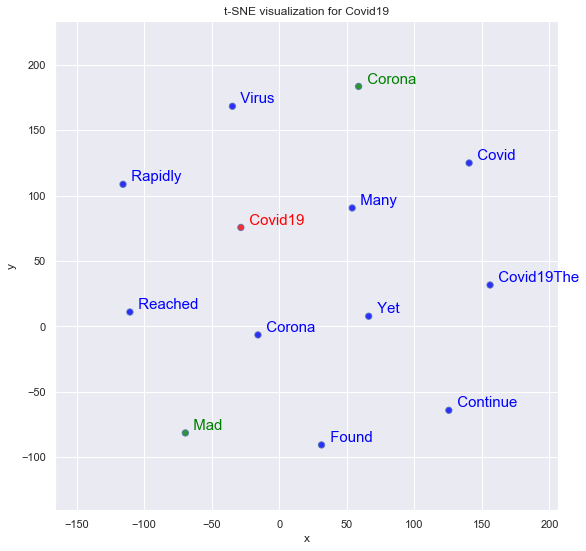

In [20]:
tsnescatterplot(w2v_model, 'covid19', ['corona', 'mad'])

In [21]:
tweets = covid_19_tweets['Tweet'].tolist()
tweets_list = []

for tweet in tweets:
    tweets_list.append(tweet.split(" "))

# -------------------------------------------------------------------------
## Bigrams

In [22]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in covid_19_tweets['words_list'].tolist()]

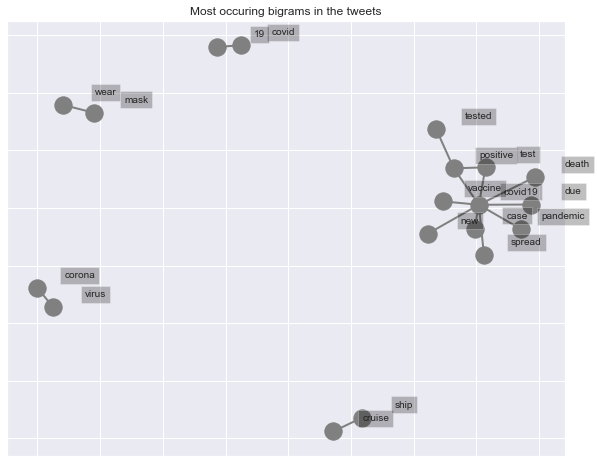

In [23]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(15),
                             columns=['bigram', 'count'])

# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 5))

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=4)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=2,
                 edge_color='grey',
                 node_color='gray',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='black', alpha=0.25),
            horizontalalignment='center', fontsize=10)

plt.title("Most occuring bigrams in the tweets")

plt.show()

# -------------------------------------------------------------------------
## Word Cloud

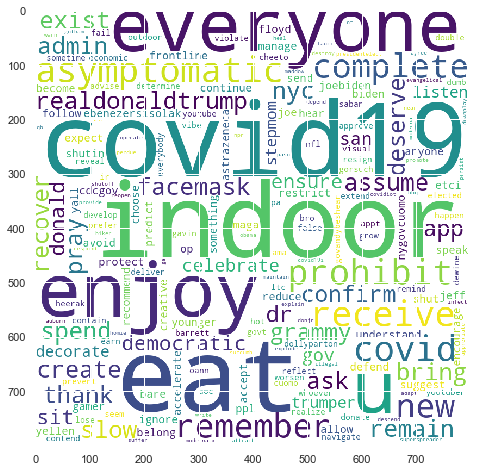

In [24]:
words_covid = list(itertools.chain(*covid_19_tweets['words_list'].tolist()))

counts_words = collections.Counter(words_covid)

wc = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(" ".join(counts_words)) 
                
plt.figure(figsize=(10,8))
plt.imshow(wc)

# -------------------------------------------------------------------------
## Sentiment Analysis

In [25]:
sentiment_objects = [TextBlob(tweet) for tweet in covid_19_tweets]

25827
[-0.11964285714285713, 'olganyc1211 hello fbi dhsgov id like report activated domestic terrorist cell namely catholic church america bioterrorism mass murder mean unchecked covid19 large gathering weaponized supreme court yes ill hold']


Text(0.5, 0, 'Polarity')

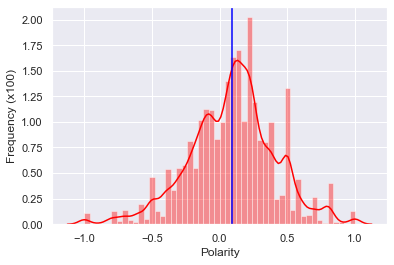

In [91]:
import plotly.figure_factory as ff

sentiment_objects = [TextBlob(tweet) for tweet in covid_19_tweets['Tweet']]

all_sentiment = [tweet.sentiment.polarity for tweet in sentiment_objects]
pos_counter = 0
neg_counter = 0
neu_counter = 0

print(len(covid_19_tweets))

sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]
print(sentiment_values[0])
# Create dataframe containing the polarity value and tweet text

sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])
sentiment_df = sentiment_df[sentiment_df.polarity != 0]

x = sentiment_df['polarity'].values # array with polarity only

sns.distplot(x, color = 'red');

# Calculating the mean
mean = sentiment_df['polarity'].mean()

#ploting the mean
plt.axvline(mean, 0,1, color = 'blue')

plt.ylabel("Frequency (x100)")
plt.xlabel("Polarity")

      
# plt.savefig('x.png')

# -------------------------------------------------------------------------
## Bar chart for polarity

In [43]:
neg = sentiment_df['polarity'].astype('float')
neg = neg[neg <= -0.1]
neg
pos = sentiment_df['polarity'].astype('float')
pos = pos[pos >= 0.1]
pos

2        0.283333
6        0.197857
7        0.350000
8        0.150000
9        0.380000
           ...   
25819    0.200000
25820    0.250000
25821    0.166667
25823    0.200000
25826    0.166667
Name: polarity, Length: 9317, dtype: float64

In [44]:
neutrals = sentiment_df['polarity'].astype('float')
neutrals = neutrals[neutrals < 0.1]
neutrals = neutrals[neutrals > -0.1]
neutrals

21       0.050000
24       0.045455
31      -0.054545
43       0.028571
52       0.031250
           ...   
25794    0.037500
25801    0.002083
25804    0.066667
25807    0.016667
25810    0.066667
Name: polarity, Length: 3670, dtype: float64

In [72]:
tweet_polarity = px.bar(x = ["Negative", "Neutral" ,"Positive"], 
                    y = [len(pos),len(neutrals),len(neg)], 
                    title = '', 
                    labels = dict(x = 'Distribution of sentiment', y = 'Number of tweets'),
                    color = ["Negative", "Neutral" ,"Positive"])
                    
tweet_polarity.show()

# -------------------------------------------------------------------------
## Frequency of words

In [200]:
words_covid = list(itertools.chain(*covid_19_tweets['words_list'].tolist()))
words_covid_df = pd.DataFrame(columns = ['words'])
words_covid_df['words'] = words_covid

words_covid_df = words_covid_df['words'].value_counts(sort=True).to_frame().reset_index().rename(columns={'words':'occurences','index': 'words'})
words_covid_df = words_covid_df.head(30)
word_occurences = px.bar(x = words_covid_df['words'], 
                    y = words_covid_df['occurences'],
                    title = '', 
                    labels = dict(x = 'Distribution of sentiment', y = 'Number of tweets'))
                    
word_occurences.show()

# -------------------------------------------------------------------------
## Over time

# -------------------------------------------------------------------------
## LDA

In [28]:
tweets_column = covid_19_tweets['Tweet']
count_vectorizer = CountVectorizer(min_df=10, max_df=0.95, ngram_range=(1,1), stop_words='english')
feature_matrix = count_vectorizer.fit_transform(tweets_column)

In [29]:
lda_model = LatentDirichletAllocation(n_components=2, max_iter=100, learning_method='online', random_state=43,
                                     batch_size=128, evaluate_every=-1, n_jobs=-1)

lda_output = lda_model.fit_transform(feature_matrix)
display(lda_output)

KeyboardInterrupt: 

In [ ]:
display(lda_output.shape)